<a href="https://colab.research.google.com/github/luizgonzagasilva/kaggle-wids2022/blob/main/EXploracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download conjunto de dados

In [1]:
!pip install kaggle

!mkdir .kaggle
!touch .kaggle/kaggle.json

api_token = {"username":"luizgonzagajunior","key":"374402bd0762f08f49a322b975e8c89f"}

import json
import zipfile
import os
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /content/.kaggle/kaggle.json

In [2]:
!rm /root/.kaggle/kaggle.json -f

In [3]:
!mv .kaggle /root/
!chmod 600 /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json

{"username": "luizgonzagajunior", "key": "374402bd0762f08f49a322b975e8c89f"}

In [4]:
!kaggle competitions download -c widsdatathon2022

  0% 0.00/1.65M [00:00<?, ?B/s]
100% 1.65M/1.65M [00:00<00:00, 55.0MB/s]
  0% 0.00/157k [00:00<?, ?B/s]
100% 157k/157k [00:00<00:00, 139MB/s]
  0% 0.00/94.8k [00:00<?, ?B/s]
100% 94.8k/94.8k [00:00<00:00, 170MB/s]


In [5]:
! ls -l

total 1948
drwxr-xr-x 1 root root    4096 Feb  1 14:32 sample_data
-rw-r--r-- 1 root root   97062 Feb 14 00:59 sample_solution.csv
-rw-r--r-- 1 root root  160497 Feb 14 00:59 test.csv.zip
-rw-r--r-- 1 root root 1726416 Feb 14 00:59 train.csv.zip


# Exploração

In [6]:
import pandas as pd
df = pd.read_csv('train.csv.zip')

In [16]:
df.shape

(75757, 64)

In [17]:
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


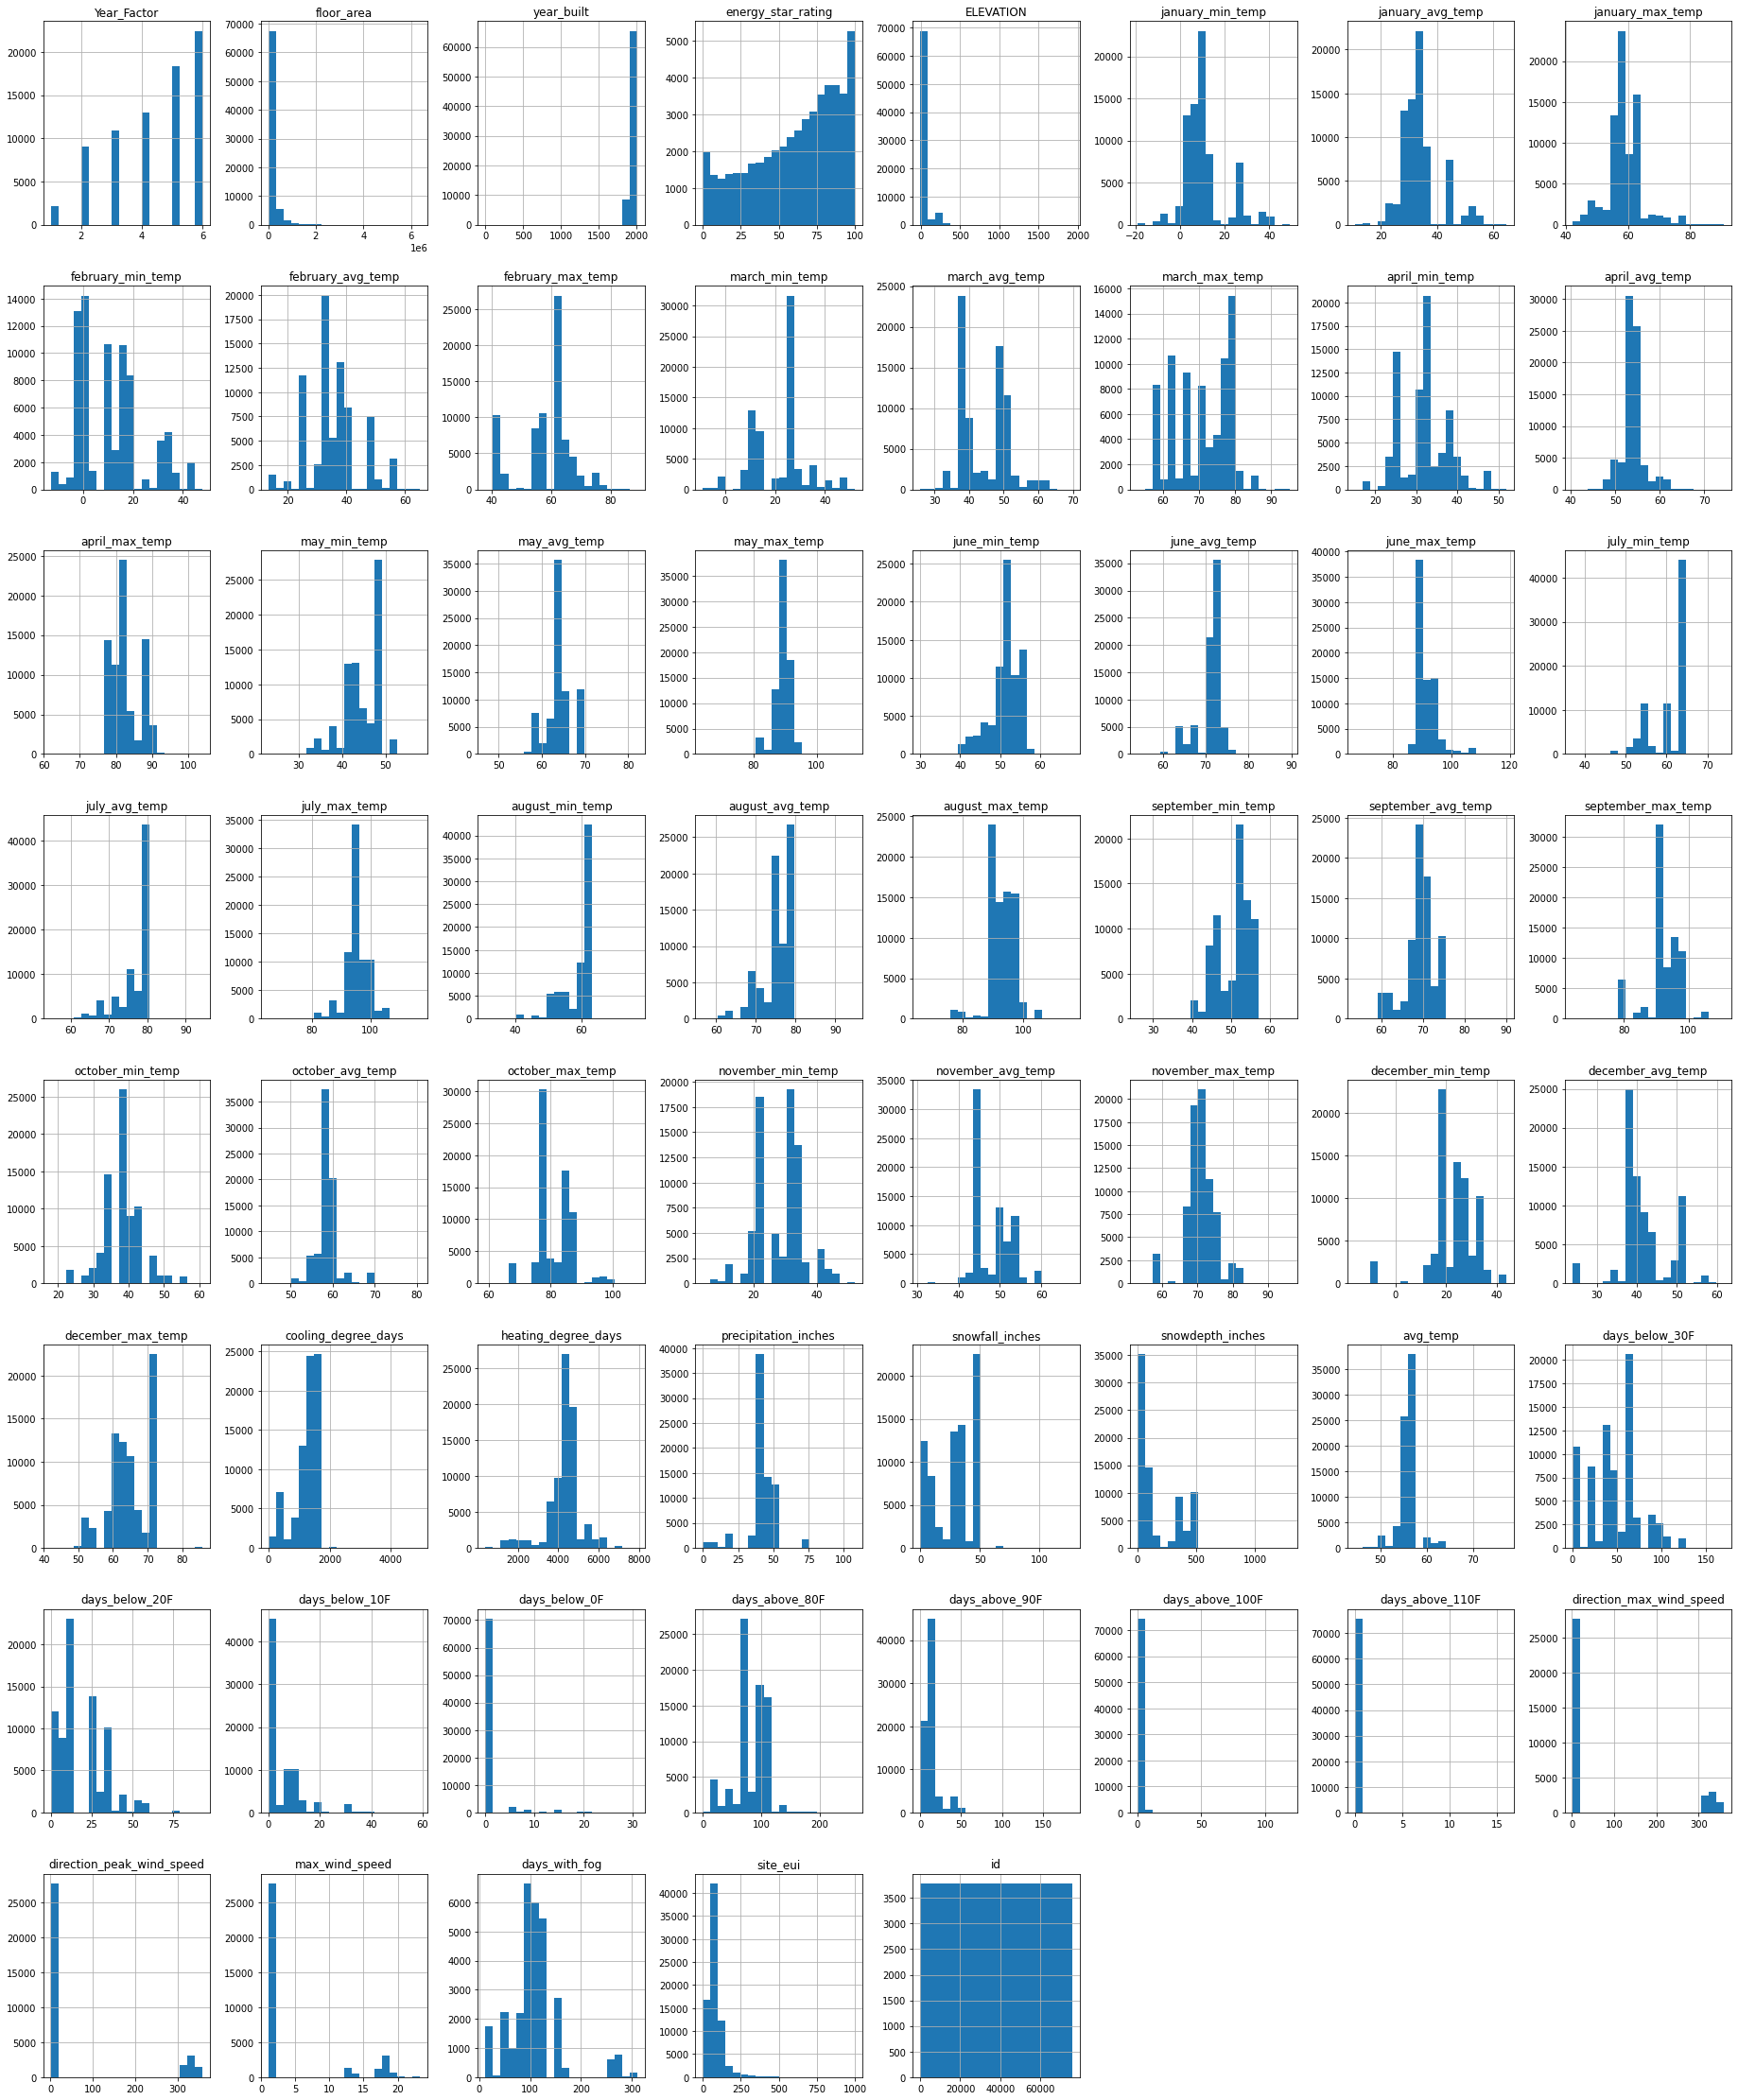

In [18]:
# distribuição das variáveis
_ = df.hist(figsize=[32,40], bins=20)

In [19]:
# somatoria de valores nulos
df.isnull().sum()

Year_Factor                      0
State_Factor                     0
building_class                   0
facility_type                    0
floor_area                       0
                             ...  
direction_peak_wind_speed    41811
max_wind_speed               41082
days_with_fog                45796
site_eui                         0
id                               0
Length: 64, dtype: int64

In [20]:
# somente valores nulos
df_null = pd.DataFrame(df.isnull().sum(), columns=['qtd_nulos']).reset_index()
df_null.loc[df_null['qtd_nulos']>0, :]

,index,qtd_nulos
5,year_built,1837
6,energy_star_rating,26709
58,direction_max_wind_speed,41082
59,direction_peak_wind_speed,41811
60,max_wind_speed,41082
61,days_with_fog,45796


In [21]:
indices = df_null.loc[df_null['qtd_nulos']>0, :]['index'].values
indices

array(['year_built', 'energy_star_rating', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog'],
      dtype=object)

In [22]:
df[indices].head()

,year_built,energy_star_rating,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,1942.0,11.0,1.0,1.0,1.0,NaN
1,1955.0,45.0,1.0,NaN,1.0,12.0
2,1951.0,97.0,1.0,NaN,1.0,12.0
3,1980.0,46.0,1.0,NaN,1.0,12.0
4,1985.0,100.0,1.0,1.0,1.0,NaN


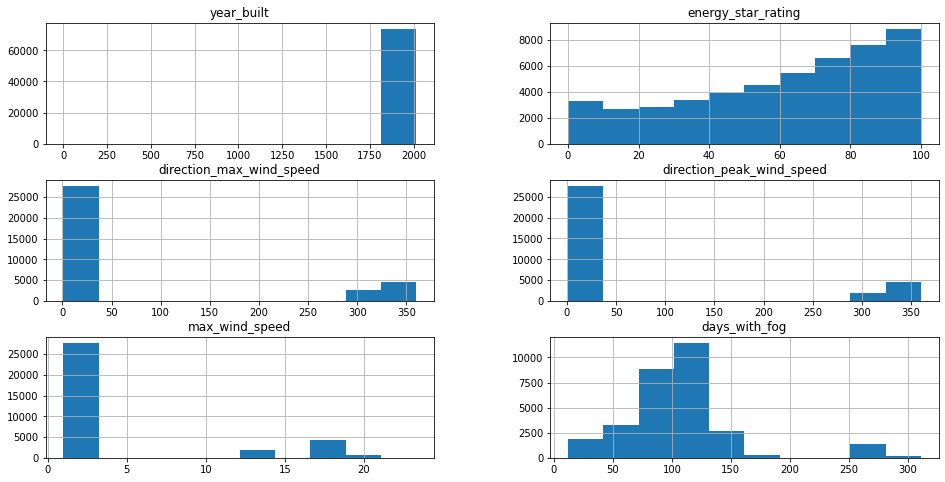

In [23]:
# distribuição campos nulos
_ = df[indices].hist(figsize=[16,8])

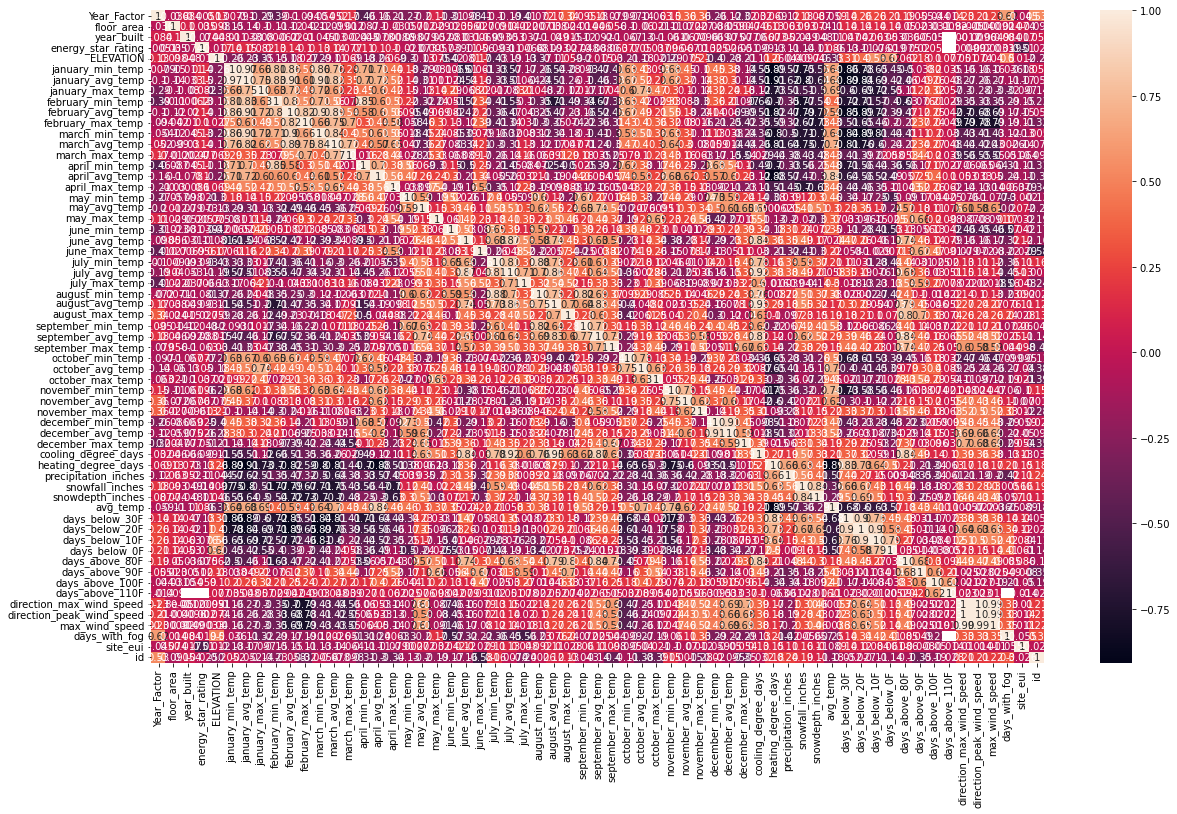

In [24]:
import seaborn as sns 
import matplotlib.pyplot as plt
# Calculando a matriz de variâncias e covariâncias
corr = df.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(20, 12))

# Plotando o heatmap com a biblioteca seaborn
ax = sns.heatmap(corr, annot = True)

In [44]:
# as 5 variáveis mais correlacionadas com a variável target
top05 = corr['site_eui'].abs().sort_values(ascending=False).head(60)
top05 = top05.sort_values()
data_frame = df[top05.index]
top05

days_above_90F               0.007980
direction_max_wind_speed     0.010217
max_wind_speed               0.010639
ELEVATION                    0.011798
november_max_temp            0.012002
direction_peak_wind_speed    0.013589
days_above_110F              0.014190
year_built                   0.017162
october_max_temp             0.021272
id                           0.026500
august_max_temp              0.028359
june_max_temp                0.029233
may_max_temp                 0.031679
october_avg_temp             0.040162
june_min_temp                0.042291
Year_Factor                  0.045179
july_max_temp                0.047884
days_above_100F              0.050029
december_avg_temp            0.050328
december_max_temp            0.054068
days_with_fog                0.055388
december_min_temp            0.058888
september_min_temp           0.060203
days_below_0F                0.060981
march_max_temp               0.064302
november_avg_temp            0.069882
may_avg_temp

# Encoder e Normalização

In [8]:
# define vetor com os nomes das variaveis numericas e categoricas
var_categoricos = ['State_Factor','building_class','facility_type']
var_numericos = list(set(df.columns.values) - set(var_categoricos))

# remove identificador da construção
var_numericos.remove('id')

# remove variável alvo
var_numericos.remove('site_eui')

In [9]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer


# cria os pipelines
pip_numerico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

pip_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder()),
    ('scaler', StandardScaler())])

# define as transformacoes no dados
transformacao = ColumnTransformer(
    transformers=[
        ('transformacao numerica', pip_numerico, var_numericos),
        ('transformacao categorica', pip_categorico, var_categoricos),        
    ])

# aplica as transformacoes
dados_transformados = transformacao.fit_transform(df[var_categoricos + var_numericos])

# matrix esparça para densa
#dados_transformados = dados_transformados.todense()
dados_transformados_com_classe = np.c_[dados_transformados, df['site_eui']]
dados_transformados_com_classe.round(2)

array([[-1.3700e+00,  2.3100e+00, -4.3000e-01, ..., -1.1600e+00,
        -1.1100e+00,  2.4868e+02],
       [-1.3700e+00,  2.3100e+00, -4.3000e-01, ..., -1.1600e+00,
         2.5000e+00,  2.6500e+01],
       [-1.3700e+00,  2.3100e+00, -4.3000e-01, ..., -1.1600e+00,
         1.9000e+00,  2.4690e+01],
       ...,
       [-4.3900e+00,  3.3000e-01, -3.8300e+00, ..., -1.1600e+00,
        -2.0600e+00,  4.8400e+01],
       [-4.3900e+00,  3.3000e-01, -3.8300e+00, ..., -1.1600e+00,
        -2.0600e+00,  5.9202e+02],
       [-3.7900e+00,  3.8000e-01, -3.4300e+00, ...,  8.6000e-01,
        -2.2300e+00,  2.9150e+01]])

In [10]:
# retornando a descrição dos atributos
nomes = []
nomes = nomes + var_numericos + var_categoricos
nomes.append("site_eui")

dataframe_processado = pd.DataFrame(data = dados_transformados_com_classe, columns=nomes)
dataframe_processado.head()

,september_avg_temp,january_avg_temp,september_max_temp,july_min_temp,max_wind_speed,february_max_temp,may_min_temp,snowfall_inches,november_min_temp,november_max_temp,floor_area,heating_degree_days,april_max_temp,june_avg_temp,january_max_temp,avg_temp,cooling_degree_days,october_max_temp,august_avg_temp,december_max_temp,november_avg_temp,december_avg_temp,days_below_30F,Year_Factor,august_max_temp,june_min_temp,snowdepth_inches,days_below_0F,may_avg_temp,april_min_temp,october_avg_temp,december_min_temp,days_with_fog,march_avg_temp,february_avg_temp,energy_star_rating,july_max_temp,march_min_temp,days_above_100F,ELEVATION,days_above_110F,days_above_80F,july_avg_temp,january_min_temp,year_built,october_min_temp,direction_peak_wind_speed,may_max_temp,precipitation_inches,april_avg_temp,september_min_temp,days_below_10F,march_max_temp,direction_max_wind_speed,august_min_temp,june_max_temp,days_below_20F,days_above_90F,february_min_temp,State_Factor,building_class,facility_type,site_eui
0,-1.372888,2.314092,-0.433216,-2.052056,-0.730182,1.724835,0.308031,-1.635885,2.008837,0.182378,-0.424272,-1.655776,-1.136779,-3.692394,1.670279,0.355007,-2.776721,0.334141,-3.453236,1.074179,1.38657,1.303147,-1.767376,-2.28876,-1.829277,-0.331322,-0.940595,-0.302936,-2.466149,1.607036,1.623867,1.471405,4.457125e-16,1.385627,1.698778,-2.170027,-2.77693,1.838593,-0.124112,-0.611748,-0.017181,-2.717656,-3.391255,2.618884,-0.281595,1.725426,-7.082715e-01,-1.741174,-2.439607,0.68593,0.281601,-0.69105,1.185035,-0.73882,-1.466709,-0.38853,-1.205856,-1.284612,1.850925,-2.735028,-1.163089,-1.110481,248.682615
1,-1.372888,2.314092,-0.433216,-2.052056,-0.730182,1.724835,0.308031,-1.635885,2.008837,0.182378,0.437535,-1.655776,-1.136779,-3.692394,1.670279,0.355007,-2.776721,0.334141,-3.453236,1.074179,1.38657,1.303147,-1.767376,-2.28876,-1.829277,-0.331322,-0.940595,-0.302936,-2.466149,1.607036,1.623867,1.471405,-3.046786e+00,1.385627,1.698778,-0.695842,-2.77693,1.838593,-0.124112,-0.621640,-0.017181,-2.717656,-3.391255,2.618884,0.073583,1.725426,-8.145960e-17,-1.741174,-2.439607,0.68593,0.281601,-0.69105,1.185035,-0.73882,-1.466709,-0.38853,-1.205856,-1.284612,1.850925,-2.735028,-1.163089,2.496116,26.500150
2,-1.372888,2.314092,-0.433216,-2.052056,-0.730182,1.724835,0.308031,-1.635885,2.008837,0.182378,0.461940,-1.655776,-1.136779,-3.692394,1.670279,0.355007,-2.776721,0.334141,-3.453236,1.074179,1.38657,1.303147,-1.767376,-2.28876,-1.829277,-0.331322,-0.940595,-0.302936,-2.466149,1.607036,1.623867,1.471405,-3.046786e+00,1.385627,1.698778,1.558795,-2.77693,1.838593,-0.124112,-0.621640,-0.017181,-2.717656,-3.391255,2.618884,-0.035703,1.725426,-8.145960e-17,-1.741174,-2.439607,0.68593,0.281601,-0.69105,1.185035,-0.73882,-1.466709,-0.38853,-1.205856,-1.284612,1.850925,-2.735028,-1.163089,1.895016,24.693619
3,-1.372888,2.314092,-0.433216,-2.052056,-0.730182,1.724835,0.308031,-1.635885,2.008837,0.182378,-0.448240,-1.655776,-1.136779,-3.692394,1.670279,0.355007,-2.776721,0.334141,-3.453236,1.074179,1.38657,1.303147,-1.767376,-2.28876,-1.829277,-0.331322,-0.940595,-0.302936,-2.466149,1.607036,1.623867,1.471405,-3.046786e+00,1.385627,1.698778,-0.652483,-2.77693,1.838593,-0.124112,-0.621640,-0.017181,-2.717656,-3.391255,2.618884,0.756618,1.725426,-8.145960e-17,-1.741174,-2.439607,0.68593,0.281601,-0.69105,1.185035,-0.73882,-1.466709,-0.38853,-1.205856,-1.284612,1.850925,-2.735028,-1.163089,-1.711580,48.406926
4,-1.372888,2.314092,-0.433216,-2.052056,-0.730182,1.724835,0.308031,-1.635885,2.008837,0.182378,-0.404999,-1.655776,-1.136779,-3.692394,1.670279,0.355007,-2.776721,0.334141,-3.453236,1.074179,1.38657,1.303147,-1.767376,-2.28876,-1.829277,-0.331322,-0.940595,-0.302936,-2.466149,1.607036,1.623867,1.471405,4.457125e-16,1.385627,1.698778,1.688870,-2.77693,1.838593,-0.124112,-0.611748,-0.017181,-2.717656,-3.391255,2.618884,0.893224,1.725426,-7.082715e-01,-1.741174,-2.439607,0.68593,0.281601,-0.69105,1.185035,-0.73882,-1.466709,-0.38853,-1.205856,-1.284612,1.850925

# Classificação

## Regressão linear

In [41]:
from sklearn.linear_model import LinearRegression

X = dataframe_processado[list(top05[:5].index)].to_numpy()
y = dataframe_processado['site_eui'].to_numpy()

lin = LinearRegression(fit_intercept=True)
lin.fit(X, y)

print(lin.coef_.round(2))
print(lin.score(X, y))

[ -1.7    3.63  14.65 -17.88 -21.1 ]
0.164397585076422


## Regresão linear com transformação

In [38]:
from sklearn.preprocessing import PolynomialFeatures

X = dataframe_processado[list(top05[:5].index)].to_numpy()
y = dataframe_processado['site_eui'].to_numpy()

# Utilizando um polinomio de grau 2
p = PolynomialFeatures(degree=1)

X_Transf = p.fit_transform(X)
print(p.get_feature_names_out())
print(X_Transf)

['1' 'x0' 'x1' 'x2' 'x3' 'x4']
[[ 1.          1.69877781 -1.63588486  2.31409221  2.61888364 -2.17002702]
 [ 1.          1.69877781 -1.63588486  2.31409221  2.61888364 -0.69584172]
 [ 1.          1.69877781 -1.63588486  2.31409221  2.61888364  1.55879464]
 ...
 [ 1.          0.68922329  0.41905082  0.32910445  1.55289528  0.        ]
 [ 1.          0.68922329  0.41905082  0.32910445  1.55289528  0.        ]
 [ 1.          0.74950349 -0.01888629  0.37521334  1.65949412 -0.43569137]]


In [39]:
from sklearn.linear_model import LinearRegression

# Note que nesse caso colocamos fit_intercept = False pois já capturamos o 
# termo idependente ao fazermos a transformação anterior
lin = LinearRegression(fit_intercept=False)
lin.fit(X_Transf, y)

#print(lin.coef_.round(2))
print(lin.score(X_Transf, y))

0.16439758507642188


##  MLP

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X = dataframe_processado.drop(columns=['site_eui']).to_numpy()
y = dataframe_processado['site_eui'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
regr = MLPRegressor(hidden_layer_sizes=(62,31,14,7,3, ), activation='relu', alpha=0.0001, max_iter=500)

regr.fit(X, y)
regr.score(X, y)

0.46451600306743

In [12]:
regr.score(X_test, y_test)

0.46511022220119

# Submissão

In [107]:
import pandas as pd
df_sub = pd.read_csv('test.csv.zip')
df_sub.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761


In [108]:
# aplica as mesmas transformacoes nos dados de submissao
dados_transformados = transformacao.fit_transform(df_sub[var_categoricos + var_numericos])

# matrix esparça para densa
#dados_transformados = dados_transformados.todense()
dados_transformados_com_classe = np.c_[dados_transformados]
dados_transformados_com_classe.round(2)

array([[ 1.75, -0.9 ,  1.27, ..., -2.  , -0.85, -0.57],
       [ 1.75, -0.9 ,  1.27, ..., -2.  , -0.85, -0.57],
       [ 1.75, -0.9 ,  1.27, ..., -2.  , -0.85, -0.57],
       ...,
       [-0.53, -1.02, -1.16, ..., -0.61,  1.17, -1.33],
       [-0.53, -1.02, -1.16, ..., -0.61,  1.17, -1.33],
       [-0.53, -1.02, -1.16, ..., -0.61,  1.17, -1.33]])

In [109]:
# retornando a descrição dos atributos
nomes = []
nomes = nomes + var_numericos + var_categoricos

dataframe_processado = pd.DataFrame(data = dados_transformados_com_classe, columns=nomes)
dataframe_processado.head()

,june_max_temp,june_avg_temp,december_max_temp,days_above_80F,ELEVATION,july_min_temp,snowfall_inches,august_max_temp,march_min_temp,november_avg_temp,snowdepth_inches,march_avg_temp,days_above_90F,january_max_temp,days_above_110F,direction_peak_wind_speed,days_below_10F,august_avg_temp,march_max_temp,may_avg_temp,precipitation_inches,year_built,october_max_temp,may_min_temp,november_max_temp,days_below_20F,days_below_30F,days_above_100F,august_min_temp,direction_max_wind_speed,january_avg_temp,energy_star_rating,february_min_temp,cooling_degree_days,max_wind_speed,february_max_temp,Year_Factor,july_avg_temp,december_min_temp,july_max_temp,days_with_fog,october_avg_temp,september_max_temp,november_min_temp,october_min_temp,floor_area,september_avg_temp,avg_temp,april_avg_temp,december_avg_temp,april_min_temp,heating_degree_days,february_avg_temp,september_min_temp,days_below_0F,june_min_temp,january_min_temp,april_max_temp,may_max_temp,State_Factor,building_class,facility_type
0,1.747362,-0.901948,1.266556,-1.222555,-0.765952,-0.021704,-0.92396,-1.401998,1.631945,2.117366,-0.525195,2.114588,-0.530789,0.679483,0.0,0.000000,-0.804544,-1.491969,0.62324,0.634639,-2.324975,0.757692,1.624204,1.725789,0.290288,-0.881922,-1.283931,2.906863,0.186769,-8.713015e-15,1.99747,-1.132239,1.871769,-0.865568,5.225499e-15,-0.147081,0.0,-1.330919,1.45149,-0.858626,-1.966722e-15,1.635641,2.565423,2.097808,2.544421,-0.513332,1.209536,1.639641,1.018998,1.950412,1.906157,-2.104886,2.323864,1.552901,-0.599846,1.4308,1.964985,-0.042726,-0.080714,-1.995206,-0.854911,-0.570711
1,1.747362,-0.901948,1.266556,-1.222555,-0.602438,-0.021704,-0.92396,-1.401998,1.631945,2.117366,-0.525195,2.114588,-0.530789,0.679483,0.0,0.000000,-0.804544,-1.491969,0.62324,0.634639,-2.324975,-0.054638,1.624204,1.725789,0.290288,-0.881922,-1.283931,2.906863,0.186769,-8.713015e-15,1.99747,-0.396831,1.871769,-0.865568,5.225499e-15,-0.147081,0.0,-1.330919,1.45149,-0.858626,-1.966722e-15,1.635641,2.565423,2.097808,2.544421,-0.538395,1.209536,1.639641,1.018998,1.950412,1.906157,-2.104886,2.323864,1.552901,-0.599846,1.4308,1.964985,-0.042726,-0.080714,-1.995206,-0.854911,-0.570711
2,1.747362,-0.901948,1.266556,-1.222555,-0.551836,-0.021704,-0.92396,-1.401998,1.631945,2.117366,-0.525195,2.114588,-0.530789,0.679483,0.0,0.000000,-0.804544,-1.491969,0.62324,0.634639,-2.324975,-0.325414,1.624204,1.725789,0.290288,-0.881922,-1.283931,2.906863,0.186769,-8.713015e-15,1.99747,-2.603054,1.871769,-0.865568,5.225499e-15,-0.147081,0.0,-1.330919,1.45149,-0.858626,-1.966722e-15,1.635641,2.565423,2.097808,2.544421,-0.560371,1.209536,1.639641,1.018998,1.950412,1.906157,-2.104886,2.323864,1.552901,-0.599846,1.4308,1.964985,-0.042726,-0.080714,-1.995206,-0.854911,-0.570711
3,1.747362,-0.901948,1.266556,-1.222555,-0.641334,-0.021704,-0.92396,-1.401998,1.631945,2.117366,-0.525195,2.114588,-0.530789,0.679483,0.0,0.000000,-0.804544,-1.491969,0.62324,0.634639,-2.324975,0.191523,1.624204,1.725789,0.290288,-0.881922,-1.283931,2.906863,0.186769,-8.713015e-15,1.99747,-1.254807,1.871769,-0.865568,5.225499e-15,-0.147081,0.0,-1.330919,1.45149,-0.858626,-1.966722e-15,1.635641,2.565423,2.097808,2.544421,-0.250673,1.209536,1.639641,1.018998,1.950412,1.906157,-2.104886,2.323864,1.552901,-0.599846,1.4308,1.964985,-0.042726,-0.080714,-1.995206,-0.854911,-0.570711
4,1.747362,-0.901948,1.266556,-1.222555,-0.768218,-0.021704,-0.92396,-1.401998,1.631945,2.117366,-0.525195,2.114588,-0.530789,0.679483,0.0,1.490059,-0.804544,-1.491969,0.62324,0.634639,-2.324975,-0.522343,1.624204,1.725789,0.290288,-0.881922,-1.283931,2.906863,0.186769,2.798395e+00,1.99747,-1.213951,1.871769,-0.865568,6.866905e+00,-0.147081,0.0,-1.330919,1.45149,-0.858626,-1.713000e+00,1.635641,2.565423,2.097808,2.544421,-0.388522,1.209536,1.639641,1.018998,1.950412,1.906157,-2.104886,2.323864,1.552901,-0.599846,1.4308,1.964985,-0.042726,-0.080714,-1.995206,-0.854911,-0.570711


In [110]:
X = dataframe_processado.to_numpy()
id = df_sub['id'].to_numpy()
y_pred = regr.predict(X)

# não existe gasto negativo
#y_pred[y_pred<0]=0

In [125]:
df_submissao = pd.DataFrame(data=np.c_[id.astype(int) , y_pred], columns=['id','site_eui'])
df_submissao.to_csv('submissao.csv',index=False)

In [118]:
!kaggle competitions submit -c widsdatathon2022 -f submissao.csv -m "Message"

100% 248k/248k [00:03<00:00, 82.7kB/s]
Successfully submitted to WiDS Datathon 2022

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcb879bf50>]],
      dtype=object)

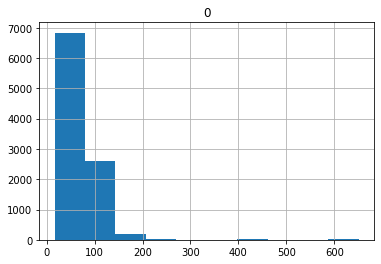

In [119]:
pd.DataFrame(y_pred).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcb8734250>]],
      dtype=object)

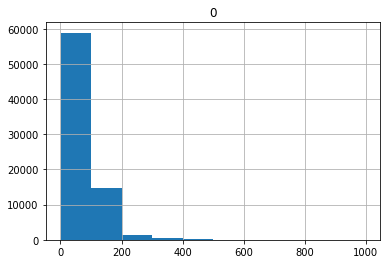

In [120]:
pd.DataFrame(y).hist()